### Bo's Dataset and Toronto Neighbourhoods 2022-02
This file loads Bo's dataset/shapefile for cycling stress classification:<br>
(https://github.com/lin-bo/Toronto_LTS_network) <br>
It also loads in neighbourhood data taken from Toronto's Open Data Portal: <br>
(https://open.toronto.ca/dataset/neighbourhood-profiles/) <br>
(https://open.toronto.ca/dataset/neighbourhoods/) <br>

Work performed:
- load data (intersection volumes and Bo's LTS data targets).
- perform EDA to see if neighbourhood and neighbourhood characteristics (like wealth) could be used as a feature. Use dummy encoding.
- Also look at the effect of being a one-way streets on cycling accessibility.

#### Imports:

In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('dark_background')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Import the raw data into a dataframe
Import both Bo's data and the neighbourhood shapes.

<AxesSubplot:>

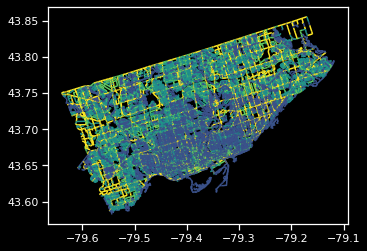

In [5]:
# import Bo's shapefile
file_path_keagan = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp'
file_path_saad = 'insert here for ease'
lts_gpd = gpd.read_file(file_path_keagan)
lts_gpd.plot(column='LTS')

In [12]:
# import the neighbourhood data
fp_k, fp_k2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/neighbourhood-profiles-2016-csv (1).csv', \
              'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/Neighbourhoods.geojson'
fp_s, fp_s2 = 'filepath1', 'filepath2'

neighbourhood_info = pd.read_csv(fp_k)
neighbourhood_boundaries = gpd.read_file(fp_k2)

In [25]:
print(neighbourhood_info.shape)
neighbourhood_info.head()

(2383, 146)


,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [48]:
print(neighbourhood_boundaries.shape)
neighbourhood_boundaries['CLASSIFICATION'] = neighbourhood_boundaries['CLASSIFICATION'].fillna('Not Classified')
neighbourhood_boundaries.head(2)

(140, 18)


,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,CLASSIFICATION,CLASSIFICATION_CODE,geometry
0,11481,2480141,26005521,None,96,96,Casa Loma (96),Casa Loma (96),None,None,None,None,17545105,3.678385e+06,8214.176485,Not Classified,None,"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,11482,2480140,26005520,None,95,95,Annex (95),Annex (95),None,None,None,None,17545121,5.337192e+06,10513.883143,Not Classified,None,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."


<AxesSubplot:>

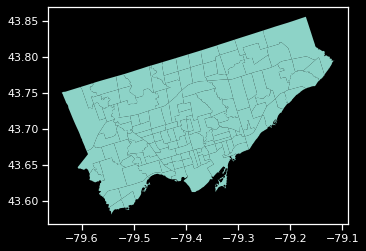

In [49]:
neighbourhood_boundaries.plot()

#### Join neighbourhoods to road segments and their corresponding information
The neighbourhoods_profile csv is structured strangely but contains all census info; this is very useful. <br>
Also, the neighbourhood rows in the info df and the rows in the boundaries gdf line up. <br>
This means the names are probably shared, which will help with merging their info together.

In [50]:
# Try merging the Neighbourhood boundaries to the LTS data.
neighbourhood_metre = neighbourhood_boundaries.to_crs("EPSG:26917")
lts_metre = lts_gpd.to_crs("EPSG:26917")

test_merge = gpd.sjoin(lts_metre, #left
                       neighbourhood_metre, #right
                       how='left',
                       op='within',
                      )

test_merge.head()

,OBJECTID_left,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID_right,Shape__Area,Shape__Length,CLASSIFICATION,CLASSIFICATION_CODE
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,Not Classified,None
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,Not Classified,None
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,Not Classified,None
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,Not Classified,None


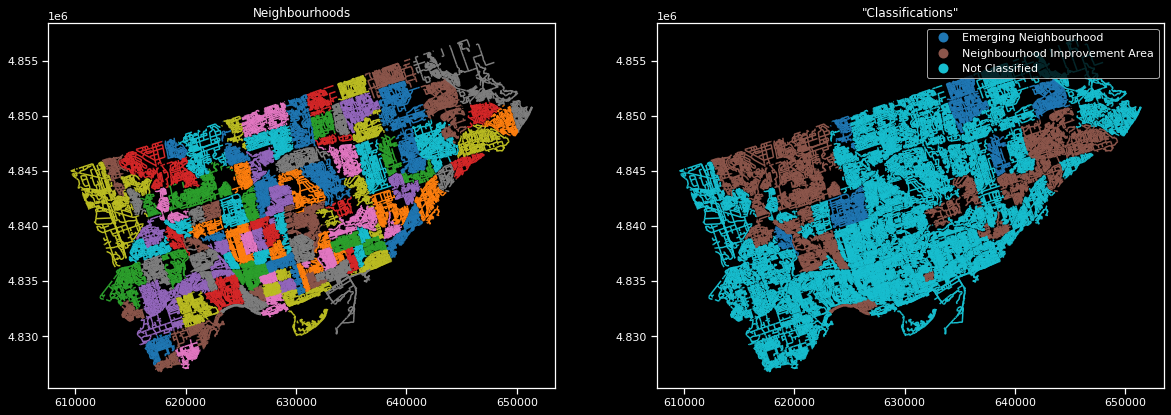

In [51]:
# Test out the merge by plotting
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
test_merge.plot(ax=axs[0], column='AREA_NAME')
test_merge.plot(ax=axs[1], column='CLASSIFICATION', legend=True)

# Attributes
axs[0].title.set_text('Neighbourhoods')
axs[1].title.set_text('"Classifications"')

### Join relevant census info with Neighbourhoods
Look to see if there is relevant info from the census on neighbourhoods. <br>
ALso, there are a lot of neighbourhoods. We probably want to group them somehow (e.g. downtown vs. suburb). <br>
SEE TAXI ASSIGNMENT PRINCIPAL COMPONENT ANALYSIS??